# 项目1-卷积神经网络的可解释性

## 友情提示
同学们可以前往课程作业区先行动手尝试！！！

## 项目描述
作业总共3个任务：
- 对输入图像求梯度得到显著性图
- 使用梯度上升法实现过滤器可视化
- 使用Lime算法实现本地简单模型近似黑盒模型

## 数据集介绍
数据集为食物分类数据集，公共有11种食物分类，总计共9866张数据。图片名称格式为{label}_{index}.jpg，例如0_1.jpg，可以通过image_nanme.split('-')[0]的形式获取分类label

## 项目要求
### 任务1：显著性图
计算输出类别相对于输入图像的梯度。并展现，如下图效果

<div align=center><img src="https://ai-studio-static-online.cdn.bcebos.com/215c371c3e174fde81e14723b04dea0c21745adcd36c41b78f79cbe52689e7ca" alt="img5" style="zoom:70%;" />

### 任务2：过滤器可视化
使用梯度上升算法(Gradient Ascent method)找出激活所选滤波器最多的图像并绘制它们（从白噪声开始）。展现如下效果。

<div align=center><img src="https://ai-studio-static-online.cdn.bcebos.com/bfb0e1ad14174eb5a3681a66778970e20893411f132549e58a7be7e30051f5fe" alt="img5" style="zoom:100%;" />

### 任务3：Lime
使用Lime算法，通过一个可说明的模型来做局部预测，实现本地简单模型近似黑盒模型。并呈现，实现如下效果。

<div align=center><img src="https://ai-studio-static-online.cdn.bcebos.com/f80df6e62c0e4aa3a8d66fd7a11e7555ceab327c953c4f6987a778a3ea56790b" alt="img5" style="zoom:85%;" />

## 数据准备

In [1]:
# 解压训练数据
!unzip data/data58273/food-11.zip
!mv food-11/ data/
!rm -rf __MACOSX

## 环境配置/安装

In [2]:
!pip install scikit-image==0.16.2
!pip install lime

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 26.5MB 12.8MB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 12.2MB/s eta 0:00:01
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 276kB 704kB/s eta 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=801bdcb6e2cd04e1e6123b1e6ea3d21e3487474466388647ba8bc33c61fe3c0d
  Stored in directory: /home/aistudio/.cache/pip/wheels/2a/62/71/0d3d919f3f29ab5416104df96b8856130af5c091fbd23371cb
Successfully built lime


In [3]:
!pip install jupyter
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 28.7MB/s eta 0:00:01
     |████████████████████████████████| 122kB 24.6MB/s eta 0:00:01
     |████████████████████████████████| 2.2MB 13.9MB/s eta 0:00:01
     |████████████████████████████████| 245kB 22.2MB/s eta 0:00:01
     |████████████████████████████████| 61kB 15.1MB/s eta 0:00:01
Looking in indexes: https://mirror.baidu.com/pypi/simple/
Exception while loading config file /etc/jupyter/jupyter_notebook_config.py
    Traceback (most recent call last):
      File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/traitlets/config/application.py", line 563, in _load_config_files
        config = loader.load_config()
      File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/traitlets/config/loader.py", line 457, in load_config
        self._read_file_as_dict()
      File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/traitl

## 开始我们的python之旅



In [4]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
import paddle
from paddle.io import Dataset
import paddle.fluid.layers as layers
from paddle.io import Dataset
paddle.disable_static()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


## 参数解析

In [5]:
args = {
      'ckptpath': 'data/data58274/checkpoint.pth',
      'dataset_dir': 'data/food-11/'
}
args = argparse.Namespace(**args)

## 模型定义和权重加载

In [6]:
# 这是助教的示范 model，写作业时一样要换成自己的
class Classifier(paddle.nn.Layer):
  def __init__(self):
    super(Classifier, self).__init__()

    def building_block(indim, outdim):
      return [
        paddle.nn.Conv2D(in_channels=indim, out_channels=outdim, kernel_size=3, stride=1, padding=1),
        paddle.nn.BatchNorm2D(outdim),
        paddle.nn.ReLU(),
      ]
    def stack_blocks(indim, outdim, block_num):
      layers = building_block(indim, outdim)
      for i in range(block_num - 1):
        layers += building_block(outdim, outdim)
      layers.append(paddle.fluid.dygraph.Pool2D(pool_size = 2, pool_stride = 2, pool_padding=0, pool_type='max'))
      return layers

    cnn_list = []
    cnn_list += stack_blocks(3, 128, 3)
    cnn_list += stack_blocks(128, 128, 3)
    cnn_list += stack_blocks(128, 256, 3)
    cnn_list += stack_blocks(256, 512, 1)
    cnn_list += stack_blocks(512, 512, 1)
    self.cnn = paddle.nn.Sequential( * cnn_list)

    dnn_list = [
      paddle.nn.Linear(512 * 4 * 4, 1024),
      paddle.nn.ReLU(),
      paddle.nn.Dropout(p = 0.3),
      paddle.nn.Linear(1024, 11),
    ]
    self.fc = paddle.nn.Sequential( * dnn_list)

  def forward(self, x):
    out = self.cnn(x)
    out = paddle.fluid.layers.reshape(out, shape=[out.shape[0], -1])
    return self.fc(out)

In [7]:
model = Classifier()
model_final = paddle.Model(model)
model_final.load('work/model_final')

## 数据集的定义和生成


In [8]:
# 助教 training 时定义的 dataset
# 因为 training 的时候助教有使用底下那些 transforms，所以 testing 时也要让 test data 使用同样的 transform
# dataset 这部分的 code 基本上不应该出现在你的作业里，你应该使用自己当初 train HW3 时的 preprocessing
from paddle.vision.transforms import Compose, RandomHorizontalFlip, Resize, RandomRotation, ToTensor
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'
        
        self.paths = paths
        self.labels = labels
        
        trainTransform = Compose([Resize(size=(128, 128)), RandomHorizontalFlip(), RandomRotation(15), ToTensor()])

        evalTransform = Compose([Resize(size=(128, 128)), ToTensor()])

        self.transform = trainTransform if mode == 'train' else evalTransform

    # 这个 FoodDataset 继承了 paddlepaddle 的 Dataset class
    # 而 __len__ 和 __getitem__ 是定义一个 paddlepaddle dataset 时一定要 implement 的两个 methods
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # 这个 method 并不是 paddlepaddle dataset 必要，只是方便未来我们想要指定「取哪几张图片」出来当作一个 batch 来 visualize
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
          image, label = self.__getitem__(index)
          images.append(image)
          labels.append(label)
        return layers.stack(images), paddle.to_tensor(labels)

# 给予 data 的路径，回传每一张图片的「路径」和「class」
def get_paths_labels(path):
    imgnames = os.listdir(path)
    imgnames.sort()
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels
train_paths, train_labels = get_paths_labels(os.path.join(args.dataset_dir, 'training'))

# 这边在 initialize dataset 时只丢「路径」和「class」，之后要从 dataset 取资料时
# dataset 的 __getitem__ method 才会动态的去 load 每个路径对应的图片
train_set = FoodDataset(train_paths, train_labels, mode='eval')

## 开始作业 4

### 显著性图

我们把一张图片丢进 model，forward 后与 label 计算出 loss。
因此与 loss 相关的有:
- image
- model parameter
- label

通常的情况下，我们想要改变模型参数来适应图片和标签。因此 loss 在计算 backward 时我们只在乎 **loss 对模型参数** 的偏微分值。但数学上图片本身也是连续的张量，我们可以计算  **loss 对图片** 的偏微分值。这个偏微分值代表「在模型参数和标签都固定下，稍微改变图片的某个像素值会对 loss 产生什么变化」。人们习惯把这个变化的剧烈程度解读成该像素的重要性 (每个像素都有自己的偏微分值)。因此把同一张图中，loss 对每个像素的偏微分值画出来，就可以看出该图中哪些位置是 model 在判断时的重要依据。

实作上非常简单，过去我们都是 forward 后算出 loss，然后进行 backward。而这个 backward，paddlepaddle 预设是计算 **loss 对模型参数** 的偏微分值，因此我们只需要用一行 code 额外告知 paddlepaddle，**图像** 也是要算偏微分的对象之一。

In [9]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model):
    # model.eval()

    # 最关键的一行 code
    # 因为我们要计算 loss 对 input image 的微分，原本 input x 只是一个 tensor，预设不需要 gradient
    # 这边我们明确的告知 paddle 这个 input x 需要gradient，这样我们执行 backward 后 x.grad 才会有微分的值
    x.stop_gradient = False

    y_pred = model(x)
    loss_func = paddle.nn.loss.CrossEntropyLoss()
    loss = loss_func(y_pred, y)
    loss.backward()
    

    # saliencies = paddle.abs(x.gradient()).detach()
    saliencies = np.abs(x.grad)
    # saliencies: (batches, channels, height, weight)
    # 因为接下来我们要对每张图片画 saliency map，每张图片的 gradient scale 很可能有巨大落差
    # 可能第一张图片的 gradient 在 100 ~ 1000，但第二张图片的 gradient 在 0.001 ~ 0.0001
    # 如果我们用同样的色阶去画每一张 saliency 的话，第一张可能就全部都很亮，第二张就全部都很暗，
    # 如此就看不到有意义的结果，我们想看的是「单一张 saliency 内部的大小关係」，
    # 所以这边我们要对每张 saliency 各自做 normalize。手法有很多种，这边只採用最简单的
    saliencies = np.stack([normalize(item) for item in saliencies])
    return saliencies

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:143: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-en

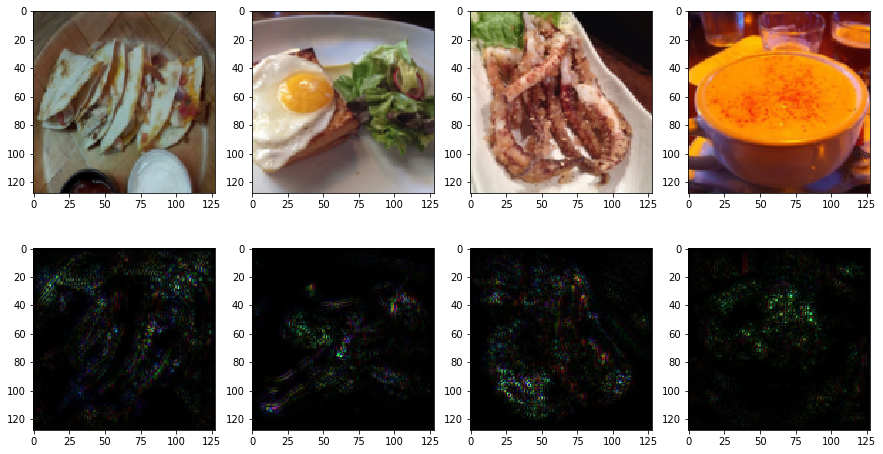

In [10]:
# 指定想要一起 visualize 的图片 indices
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)
import cv2
# 使用 matplotlib 画出来
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
index = 0
saliencies = paddle.to_tensor(saliencies)
for row, target in enumerate([images, saliencies]):
    for column, img in enumerate(target):
        img = img.numpy()
        axs[row][column].imshow(img.transpose(1, 2, 0))
        # 小知识：permute 是什么，为什么这边要用?
        # 在 paddlepaddle 的世界，image tensor 各 dimension 的意义通常为 (channels, height, width)
        # 但在 matplolib 的世界，想要把一个 tensor 画出来，形状必须为 (height, width, channels)
        # 因此 permute 是一个 paddlepaddle 很方便的工具来做 dimension 间的转换
        # 这边 img.permute(1, 2, 0)，代表转换后的 tensor，其
        # - 第 0 个 dimension 为原本 img 的第 1 个 dimension，也就是 height
        # - 第 1 个 dimension 为原本 img 的第 2 个 dimension，也就是 width
        # - 第 2 个 dimension 为原本 img 的第 0 个 dimension，也就是 channels

plt.show()
plt.close()
# 从第二张图片的 saliency，我们可以发现 model 有认出蛋黄的位置
# 从第三、四张图片的 saliency，虽然不知道 model 细部用食物的哪个位置判断，但可以发现 model 找出了食物的大致轮廓

*斜体文本*## Filter explaination

这里我们想要知道某一个 filter 到底认出了什麽。我们会做以下两件事情：
- Filter activation: 挑几张图片出来，看看图片中哪些位置会 activate 该 filter
- Filter visualization: 怎样的 image 可以最大程度的 activate 该 filter

实作上比较困难的地方是，通常我们是直接把 image 丢进 model，一路 forward 到底。如：
```
loss = model(image)
loss.backward()
```
我们要怎麽得到中间某层 CNN 的 output? 当然我们可以直接修改 model definition，让 forward 不只 return loss，也 return activation map。但这样的写法麻烦了，更改了 forward 的 output 可能会让其他部分的 code 要跟著改动。因此 paddlepaddle 提供了方便的 solution: **hook**，以下我们会再介绍。

In [11]:
paddle.summary(model, (2, 3, 128, 128))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1      [[2, 3, 128, 128]]   [2, 128, 128, 128]       3,584     
 BatchNorm2D-1  [[2, 128, 128, 128]]  [2, 128, 128, 128]        512      
    ReLU-1      [[2, 128, 128, 128]]  [2, 128, 128, 128]         0       
   Conv2D-2     [[2, 128, 128, 128]]  [2, 128, 128, 128]      147,584    
 BatchNorm2D-2  [[2, 128, 128, 128]]  [2, 128, 128, 128]        512      
    ReLU-2      [[2, 128, 128, 128]]  [2, 128, 128, 128]         0       
   Conv2D-3     [[2, 128, 128, 128]]  [2, 128, 128, 128]      147,584    
 BatchNorm2D-3  [[2, 128, 128, 128]]  [2, 128, 128, 128]        512      
    ReLU-3      [[2, 128, 128, 128]]  [2, 128, 128, 128]         0       
   Pool2D-1     [[2, 128, 128, 128]]   [2, 128, 64, 64]          0       
   Conv2D-4      [[2, 128, 64, 64]]    [2, 128, 64, 64]       147,584    
 BatchNorm2D-4   [[2, 128, 64, 64]] 

{'total_params': 14167947, 'trainable_params': 14157707}

In [12]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explaination(x, model, cnnid, filterid, iteration=100, lr=1):
  # x: 要用来观察哪些位置可以 activate 被指定 filter 的图片们
  # cnnid, filterid: 想要指定第几层 cnn 中第几个 filter
  model.eval()

  def hook(model, input, output):
    global layer_activations
    layer_activations = output
  
  hook_handle = model.cnn[cnnid].register_forward_post_hook(hook)
  # 这一行是在告诉 paddlepaddle，当 forward 「过了」第 cnnid 层 cnn 后，要先呼叫 hook 这个我们定义的 function 后才可以继续 forward 下一层 cnn
  # 因此上面的 hook function 中，我们就会把该层的 output，也就是 activation map 记录下来，这样 forward 完整个 model 后我们就不只有 loss
  # 也有某层 cnn 的 activation map
  # 注意：到这行为止，都还没有发生任何 forward。我们只是先告诉 paddlepaddle 等下真的要 forward 时该多做什麽事
  # 注意：hook_handle 可以先跳过不用懂，等下看到后面就有说明了

  # Filter activation: 我们先观察 x 经过被指定 filter 的 activation map
  model(x)
  # 这行才是正式执行 forward，因为我们只在意 activation map，所以这边不需要把 loss 存起来
  filter_activations = layer_activations[:, filterid, :, :].detach()
  
  # 根据 function argument 指定的 filterid 把特定 filter 的 activation map 取出来
  # 因为目前这个 activation map 我们只是要把他画出来，所以可以直接 detach from graph 并存成 cpu tensor
  
  # Filter visualization: 接著我们要找出可以最大程度 activate 该 filter 的图片
  # 从一张 random noise 的图片开始找 (也可以从一张 dataset image 开始找)
  # 我们要对 input image 算偏微分
  optimizer = paddle.optimizer.Adam(learning_rate=lr, parameters=model.parameters())
  # 利用偏微分和 optimizer，逐步修改 input image 来让 filter activation 越来越大
  for iter in range(iteration):
    optimizer.clear_grad()
    model(x)
    
    objective = -layer_activations[:, filterid, :, :].sum()
    # 与上一个作业不同的是，我们并不想知道 image 的微量变化会怎样影响 final loss
    # 我们想知道的是，image 的微量变化会怎样影响 activation 的程度
    # 因此 objective 是 filter activation 的加总，然后加负号代表我们想要做 maximization
    
    objective.backward()
    # 计算 filter activation 对 input image 的偏微分
    optimizer.step()
    # 修改 input image 来最大化 filter activation
  # 完成图片修改，只剩下要画出来，因此可以直接 detach 并转成 cpu tensor

  hook_handle.remove()
  # 很重要：一旦对 model register hook，该 hook 就一直存在。如果之后继续 register 更多 hook
  # 那 model 一次 forward 要做的事情就越来越多，甚至其行为模式会超出你预期 (因为你忘记哪边有用不到的 hook 了)
  # 因此事情做完了之后，就把这个 hook 拿掉，下次想要再做事时再 register 就好了。

  return filter_activations

In [13]:
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
filter_activations = filter_explaination(images, model, cnnid=15, filterid=0, iteration=100, lr=0.1)

# 根据图片中的线条，可以猜测第 15 层 cnn 其第 0 个 filter 可能在认一些线条、甚至是 object boundary
# 因此给 filter 看一堆对比强烈的线条，他会觉得有好多 boundary 可以 activate
# 画出 filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
    axs[0][i].imshow(layers.transpose(img, perm=[1, 2, 0]).numpy())
for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img).numpy())
plt.show()
plt.close()
# 从下面四张图可以看到，activate 的区域对应到一些物品的边界，尤其是颜色对比较深的边界

ValueError: (InvalidArgument) `is_test = True` CANNOT be used in train program. If you want to use global status in pre_train model, please set `use_global_stats = True`
  [Hint: Expected is_test == false, but received is_test:1 != false:0.] (at /paddle/paddle/fluid/operators/batch_norm_op.cu:531)


## Lime

Lime 的部分因为有现成的套件可以使用，因此下方直接 demo 如何使用该套件。其实非常的简单，只需要 implement 两个 function 即可。

In [13]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    model.eval()               

    input = paddle.to_tensor(input, dtype='float32')     

    input = layers.transpose(input, perm=[0, 3, 1, 2])                                                                                                
    # 需要先将 input 转成 tensor，且符合 习惯的 dimension 定义
    # 也就是 (batches, channels, height, width)
    output = model(input)                                                                                                                                             
    return output.detach().numpy()                                                                                                                                
                                                                                                                                                                             
def segmentation(input):
    # 利用 skimage 提供的 segmentation 将图片分成 100 块                                                                                                                                      
    return slic(input, n_segments=100, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(15, 8))                                                                                                                                                                 
np.random.seed(16)                                                                                                                                                       
# 让实验 reproducible

for idx, (image, label) in enumerate(zip(layers.transpose(images, perm=[0, 2, 3, 1]).numpy(), labels)):  
    x = image.astype(np.double)
    # lime 这个套件要吃 numpy array
    explainer = lime_image.LimeImageExplainer()
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
    # 基本上只要提供给 lime explainer 两个关键的 function，事情就结束了
    # classifier_fn 定义图片如何经过 model 得到 prediction
    # segmentation_fn 定义如何把图片做 segmentation
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=int(label.numpy()[0]),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                                )
    # 把 explainer 解释的结果转成图片
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    axs[idx].imshow(lime_img)

plt.show()
plt.close()
# 从以下前三章图可以看到，model 有认出食物的位置，并以该位置为主要的判断依据
# 唯一例外是第四张图，看起来 model 似乎比较喜欢直接去认「碗」的形状，来判断该图中属于 soup 这个 class
# 至于碗中的内容物被标成红色，代表「单看碗中」的东西反而有碍辨认。
# 当 model 只看碗中黄色的一坨圆形，而没看到「碗」时，可能就会觉得是其他黄色圆形的食物。

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
